In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import NearestNeighbors

In [2]:
!pip install statsmodels

In [1]:
from __future__ import division
import statsmodels

In [4]:
def abs_subgrad(x):
    if(x < 0):
        return -1
    elif(x > 0):
        return 1
    else:
        return 0

In [5]:
def append_zeros(X, Y):
    if(X.shape[1] <  Y.shape[1]):
        X_new = np.zeros([X.shape[0],Y.shape[1]])
        X_new[:,:-(Y.shape[1] - X.shape[1])] = X
        Y_new = Y
        
    else:
        Y_new = np.zeros([Y.shape[0],X.shape[1]])
        Y_new[:,:-(X.shape[1] - Y.shape[1])] = Y
        X_new = X
        
    return X_new, Y_new

In [6]:
def kNN(X, Y, k):
    
    if(X.shape[1] !=  Y.shape[1]):
        X, Y = append_zeros(X,Y)
    neigh = NearestNeighbors(k+1, metric='chebyshev')
    neigh.fit(Y)
    return neigh.kneighbors(X, k+1, return_distance=True)  

In [7]:
def MI_1(X, Y, k):
    Z = np.zeros([X.shape[0],X.shape[1]+Y.shape[1]]) 
    
    Z[:,0:X.shape[1]] = X
    Z[:,X.shape[1]:X.shape[1]+Y.shape[1]] = Y    
    dist_z, index_z = kNN(Z, Z, k)

    N = X.shape[0]
    MI_estimate = scipy.special.digamma(k) + scipy.special.digamma(N) 
    dist_x, index_x = kNN(X, X, N-1)
    dist_y, index_y = kNN(Y, Y, N-1)

    avg = 0
    for i in range(N):
        nx = 1
        a = np.where(dist_x[i,:] < dist_z[i, k], 1, 0)
        nx = nx + np.count_nonzero(a) - 1
        avg = avg + scipy.special.digamma(nx)/N
        
        ny = 1
        a = np.where(dist_y[i,:] < dist_z[i, k], 1, 0)
        ny = ny + np.count_nonzero(a) - 1
        #print(ny)
        avg = avg + scipy.special.digamma(ny)/N
    
    return MI_estimate - avg

In [8]:
def IB(X,Y,U,k, beta=-1):
    return MI_1(X,U,k) + beta*MI_1(Y,U,k)

In [9]:
def correlated_plot_2D(N, seed):
    np.random.seed(seed)
    N = int(N)
    fig, ax = plt.subplots(1,1,figsize=(12,8))
        
    Y_samples = np.random.uniform(-3,3, N)[:,np.newaxis]
    Z_samples = np.random.uniform(-0.5,0.5, N)[:,np.newaxis]

    X_samples = np.mod((Y_samples + Z_samples),3)
    U = np.zeros([N,1])
    
    ib_estimate = []
    U[0:N-2] = np.random.uniform(-3,3, N-2)[:,np.newaxis]
    xlist = np.linspace(-10.0, 6.0, 801)
    ylist = np.linspace(-10.0, 6.0, 801)
    
    Z = np.zeros([xlist.shape[0], ylist.shape[0]])
    for i in range(xlist.shape[0]):
        for j in range(ylist.shape[0]):
            U[-1] = xlist[i]
            U[-2] = ylist[j]
            Z[i,j] = IB(X_samples,Y_samples,U,1)
 
    X, Y = np.meshgrid(xlist, ylist)
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp) # Add a colorbar to a plot

In [10]:
def correlated_Gaussian_2D(N, seed, cov=0.5):
    np.random.seed(seed)
    N = int(N)
    fig, ax = plt.subplots(1,1,figsize=(12,8))
        
    X_samples, Y_samples = np.random.multivariate_normal([0, 0], [[1, cov],[cov, 1]], N).T
    X_samples,Y_samples = X_samples[:,np.newaxis], Y_samples[:,np.newaxis]
    
    U = np.zeros([N,1])
    
    ib_estimate = []
    U[0:N-2] = np.random.normal(0,1, N-2)[:,np.newaxis]
    xlist = np.linspace(-10.0, 10.0, 1001)
    ylist = np.linspace(-10.0, 10.0, 1001)
    
    Z = np.zeros([xlist.shape[0], ylist.shape[0]])
    for i in range(xlist.shape[0]):
        for j in range(ylist.shape[0]):
            U[-1] = xlist[i]
            U[-2] = ylist[j]
            Z[i,j] = IB(X_samples,Y_samples,U,1)
 
    X, Y = np.meshgrid(xlist, ylist)
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp) # Add a colorbar to a plot

In [11]:
def ret_loss(Z, W, d_x,d_y,d_u,index_z,index_w):
    
    factor = 20
    loss = 0.
    k = 1
    for i in range(Z.shape[0]):
        loss = loss + np.log(np.log(np.exp(factor*np.absolute(W[i, d_y:d_y+d_u] - W[index_w[i, k], d_y:d_y+d_u]))+np.exp(factor*np.absolute(W[i, 0:d_y] - W[index_w[i, k], 0:d_y]))))
        loss = loss - np.log(np.log(np.exp(factor*np.absolute(Z[i, d_x:d_x+d_u] - Z[index_z[i, k], d_x:d_x+d_u]))+np.exp(factor*np.absolute(Z[i, 0:d_x] - Z[index_z[i, k], 0:d_x]))))
    return loss
    

In [12]:
def gradient_fxn(u1, uk, x1, xk, wrt = "point"):
    epsilon = 0.00001
    
    c = -1
    
    if(wrt == "point"):
        c = 1
        
    a = u1 - uk
    b = x1 - xk
    
    value  = 1.0/(np.log(epsilon + np.exp(np.absolute(a)) + np.exp(np.absolute(b))) * (np.exp(np.absolute(a)) + np.exp(np.absolute(b))) + epsilon)
    value = value * (np.exp(np.absolute(a)) * abs_subgrad(a) * c + np.exp(np.absolute(b)) * abs_subgrad(b) * c)
    
    #print(value)
    #print(value[0])
    return value[0]


In [13]:
def gradient(X, Y, U, dist_z, index_z, dist_w, index_w, resp_w, resp_z, i):
    k = 1
    N = X.shape[0]
    
    grad_value = gradient_fxn(U[i,:], U[index_w[i, k],:],Y[i,:], Y[index_w[i, k],:],"point")
    
    grad_value = grad_value - gradient_fxn(U[i,:], U[index_z[i, k],:],X[i,:], X[index_z[i, k],:],"point")
    
    if(len(resp_w[0][i]) > 0):
        for j in resp_w[0][i]:
            grad_value = grad_value + gradient_fxn(U[j,:], U[i,:], Y[j,:], Y[i,:],"nbr")
            
    if(len(resp_z[0][i]) > 0):
        for j in resp_z[0][i]:
            grad_value = grad_value - gradient_fxn(U[j,:], U[i,:], X[j,:], X[i,:],"nbr")
            
    return grad_value

In [14]:
def get_resp(Z, W, d_x, d_y, d_u):
       
    k = 1
    dist_z, index_z = kNN(Z, Z, k)   
    dist_w, index_w = kNN(W, W, k)
    
    resp_z = [[],[]] # 1st element = who it affects, 2nd element = how it's own nearest neighbour is determined
    resp_w = [[],[]]
    
    for i in range(Z.shape[0]):
        resp_z[0].append([])
        resp_z[1].append(0)
        resp_w[0].append([])
        resp_w[1].append(0)
    
    for i in range(Z.shape[0]):
        resp_z[0][index_z[i, k]].append(i)
        
        if(np.absolute(Z[i, 0:d_x] - Z[index_z[i, k], d_x:d_x+d_u]) == dist_z[i, k]):
            resp_z[1][i] = 1
            
        resp_w[0][index_w[i, k]].append(i)
        
        if(np.absolute(W[i, 0:d_y] - W[index_w[i, k], d_y:d_y+d_u]) == dist_w[i, k]):
            resp_w[1][i] = 1
    
    return resp_z,resp_w, dist_z, index_z, dist_w, index_w
    

In [15]:
def gradient_descent(X, Y, U, iterations=10000):
    
    art_loss = []
    IB_loss = []
    IB3_loss = []
    N = X.shape[0]
    d_x = X.shape[1]
    d_y = Y.shape[1]
    d_u = U.shape[1]
    best_U = U
    temp = U
    IB_min = 0
    count = 1
    
    Z = np.zeros([N,d_x+d_u]) 
    
    Z[:,0:d_x] = X
    Z[:,d_x:d_x + d_u] = U    
    
    W = np.zeros([N,d_y+d_u]) 
    
    W[:,0:d_y] = Y
    W[:,d_y:d_y+d_u] = U    
    
    init_step_size = 0.1
    
    resp_z, resp_w, dist_z, index_z, dist_w, index_w = get_resp(Z,W,d_x,d_y,d_u)
    
    for a in range(iterations):
        
        step_size = init_step_size*(1/np.power(a+1, 0.7))
        
        for b in range(N):
            
            grad = gradient(X, Y, temp, dist_z, index_z, dist_w, index_w, resp_z, resp_w, b)
            
            #print(grad)
            temp[b,:] = temp[b,:] - step_size*grad
    
        
        Z[:,d_x:d_x + d_u] = temp
        W[:,d_y:d_y+d_u] = temp
        
        resp_z, resp_w, dist_z, index_z, dist_w, index_w = get_resp(Z,W,d_x,d_y,d_u)
        
        art_loss.append(ret_loss(Z, W, d_x,d_y,d_u, index_z, index_w))
        
        IB_val = IB(X,Y,temp,1,-1)
        
        IB_val_3 = IB(X,Y,temp,3,-1)
        
        IB_loss.append(IB_val)
        IB3_loss.append(IB_val_3)
        
        if(IB_val < IB_min):
            best_U = temp
            IB_min = IB_val
            count = count + 1
        
        #if(a % 500 == 0):
    
            #print("Loss Fxn = ", art_loss[-1])
            #print("IB = ", IB_loss[-1])
    
    return art_loss, IB_loss, IB3_loss, best_U, IB_min, count
            

In [33]:
np.random.seed(3)

N = 100
X_samples, Y_samples = np.random.multivariate_normal([0, 0], [[2, 0.3],[0.3, 2]], N).T
X_samples,Y_samples = X_samples[:,np.newaxis], Y_samples[:,np.newaxis]

In [67]:
np.random.seed(1)

U = np.random.normal(0,2, N)[:,np.newaxis]

In [68]:
temp_U = np.zeros(U.shape)
temp_U = temp_U + U

In [72]:
print(IB(X_samples,Y_samples,temp_U,3,-1))
iterations = 5000

a = np.arange(iterations)

-0.04621905188769748


In [73]:
iterations = 5000

a = np.arange(iterations)
art_loss, IB_loss, IB3_loss, best_U, IB_min, count = gradient_descent(X_samples, Y_samples, temp_U, iterations)

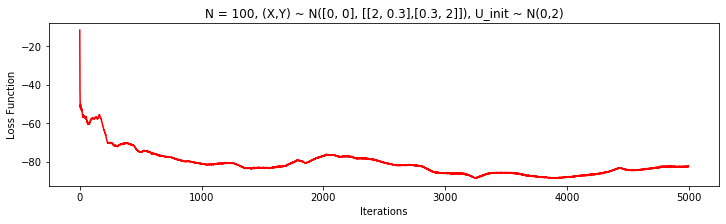

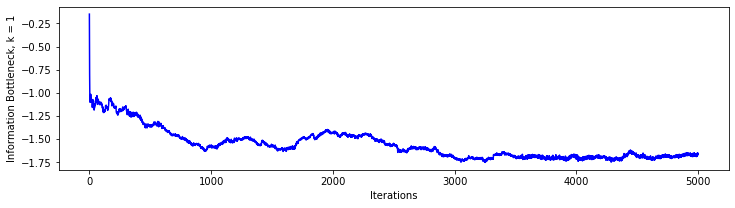

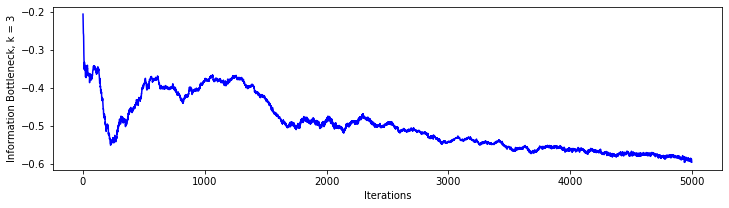

In [74]:
plt.figure(figsize=(12,3))
plt.plot(a,art_loss, c='r')
plt.ylabel("Loss Function")
plt.xlabel("Iterations")
plt.title("N = 100, (X,Y) ~ N([0, 0], [[2, 0.3],[0.3, 2]]), U_init ~ N(0,2)")
plt.show()
plt.figure(figsize=(12,3))
plt.plot(a,IB_loss, c='b')
plt.ylabel("Information Bottleneck, k = 1")
plt.xlabel("Iterations")
plt.show()
plt.figure(figsize=(12,3))
plt.plot(a,IB3_loss, c='b')
plt.ylabel("Information Bottleneck, k = 3")
plt.xlabel("Iterations")
plt.show()

In [190]:
#best_U = np.array(best_U)
print(best_U[:], IB_min)

[[-0.07362244]
 [ 1.08137933]
 [ 3.23364573]
 [ 1.43909575]
 [ 0.72356956]
 [ 1.94632933]
 [-1.2722896 ]
 [-1.59458876]
 [ 1.82232873]
 [ 0.0082927 ]
 [-2.46987987]
 [-0.07339258]
 [-0.92880522]
 [ 1.43928672]
 [-3.56455923]
 [-2.47038388]
 [ 3.23358806]
 [ 5.86092212]
 [-0.29601371]
 [ 0.68287363]
 [-3.02069276]
 [ 0.35717786]
 [-0.9288796 ]
 [-2.4699498 ]
 [ 2.80217888]] -1.319763347763348


In [41]:
best_1 = IB(X_samples,Y_samples,best_U,3,-1)
print(best_1)
a = []
for entry in best_U:
    a.append(entry[0])
    
kernel = scipy.stats.gaussian_kde(a)
x_grid = np.linspace(-7,8, 1500)
A = np.reshape(kernel(x_grid).T, x_grid.shape)

-0.5958301490451143


In [46]:
best_2 = IB(X_samples,Y_samples,best_U,3,-1)
print(best_2)
a = []
for entry in best_U:
    a.append(entry[0])
    
kernel = scipy.stats.gaussian_kde(a)
x_grid = np.linspace(-7,8, 1500)
B = np.reshape(kernel(x_grid).T, x_grid.shape)

-0.2565948636061979


In [51]:
best_3 = IB(X_samples,Y_samples,best_U,3,-1)
print(best_3)
a = []
for entry in best_U:
    a.append(entry[0])
    
kernel = scipy.stats.gaussian_kde(a)
x_grid = np.linspace(-7,8, 1500)
C = np.reshape(kernel(x_grid).T, x_grid.shape)

-0.5401424227460749


In [56]:
best_4 = IB(X_samples,Y_samples,best_U,3,-1)
print(best_4)
a = []
for entry in best_U:
    a.append(entry[0])
    
kernel = scipy.stats.gaussian_kde(a)
x_grid = np.linspace(-7,8, 1500)
D = np.reshape(kernel(x_grid).T, x_grid.shape)

-0.9033075039953271


In [61]:
best_5 = IB(X_samples,Y_samples,best_U,3,-1)
print(best_5)
a = []
for entry in best_U:
    a.append(entry[0])
    
kernel = scipy.stats.gaussian_kde(a)
x_grid = np.linspace(-7,8, 1500)
E = np.reshape(kernel(x_grid).T, x_grid.shape)

-0.31614940631257493


In [194]:
best_2

-0.40739882339882394

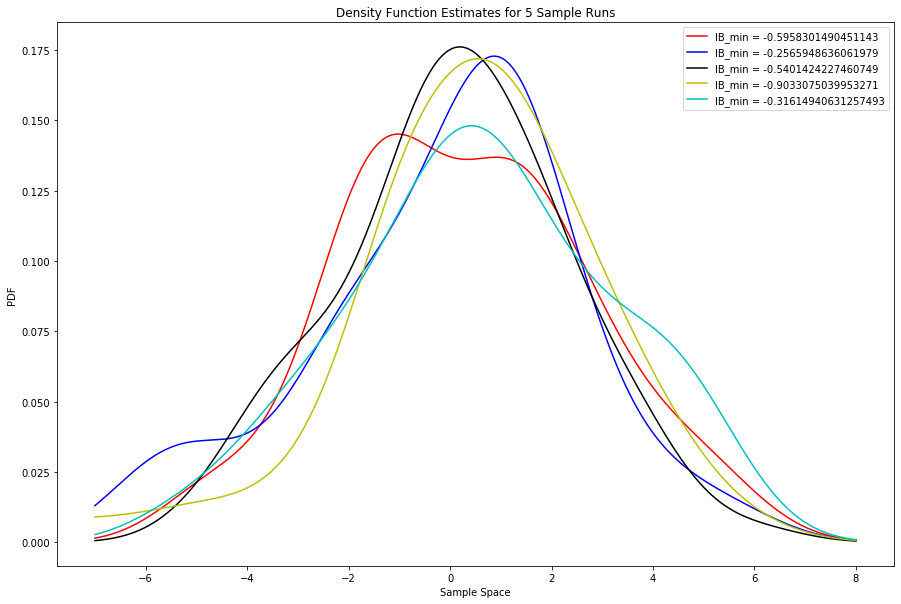

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
label1 = "IB_min = " + str(best_1)
label2 = "IB_min = " + str(best_2)
label3 = "IB_min = " + str(best_3)
label4 = "IB_min = " + str(best_4)
label5 = "IB_min = " + str(best_5)
plt.plot(x_grid, A, c='r', label=label1)
plt.plot(x_grid, B, c='b', label=label2)
plt.plot(x_grid, C, c='k', label=label3)
plt.plot(x_grid, D, c='y', label=label4)
plt.plot(x_grid, E, c='c', label=label5)
plt.ylabel("PDF")
plt.xlabel("Sample Space")
plt.title("Density Function Estimates for 5 Sample Runs")
plt.legend(loc='upper right')

plt.show()

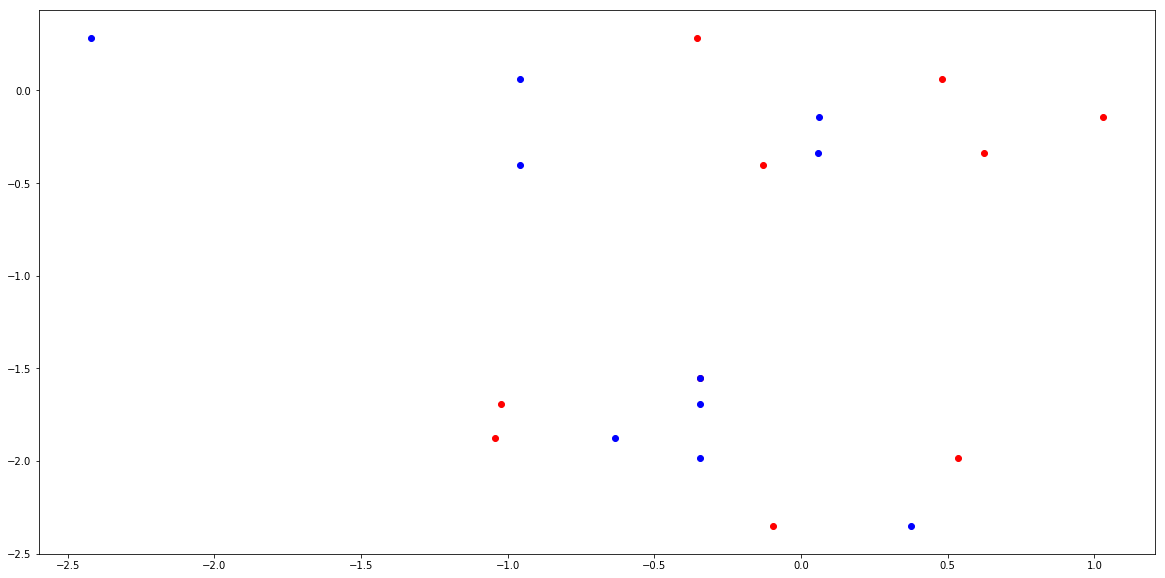

In [229]:
plt.figure(figsize=(20,10))
plt.scatter(X_samples,Y_samples, c='r')
plt.scatter(best_U,Y_samples, c='b')
plt.show()

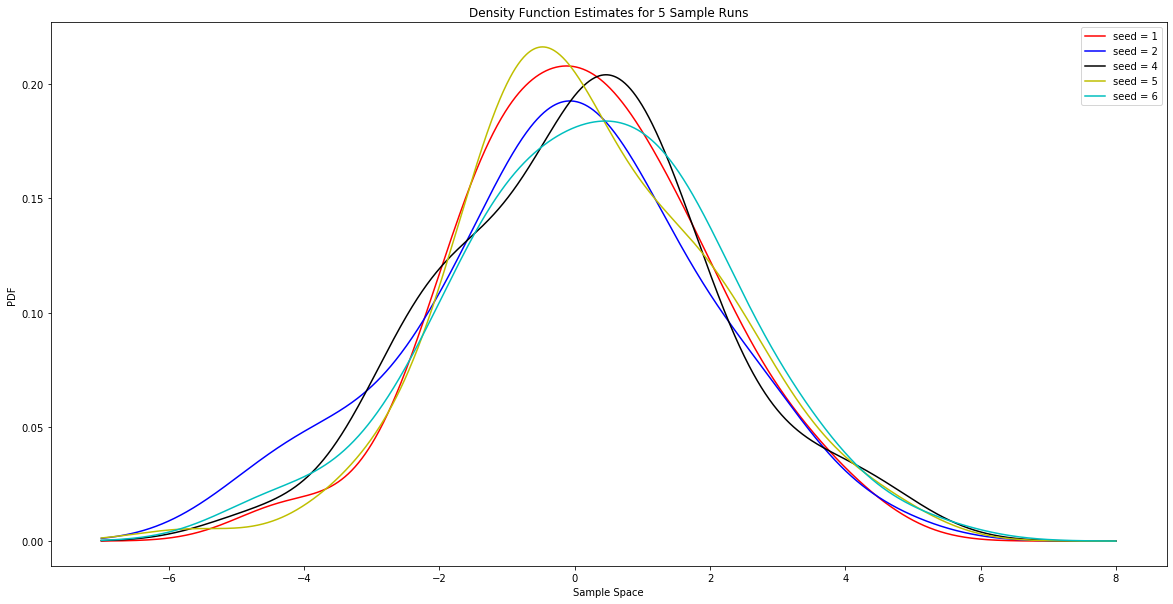

In [65]:
colors = ['r', 'b', 'k', 'y', 'c']
seeds = [1, 2, 4, 5 , 6]
plt.figure(figsize=(20,10))

for i, color in zip(range(5), colors):
    np.random.seed(seeds[i])
    U = np.random.normal(0,2, 100)[:,np.newaxis]
    a = []
    for entry in U:
        a.append(entry[0])
    
    kernel = scipy.stats.gaussian_kde(a, bw_method = 'silverman')
    x_grid = np.linspace(-7,8, 1500)
    A = np.reshape(kernel(x_grid).T, x_grid.shape)
    label5 = "seed = " + str(seeds[i])
    plt.plot(x_grid, A, c=color, label=label5)

plt.ylabel("PDF")
plt.xlabel("Sample Space")
plt.title("Density Function Estimates for 5 Sample Runs")
plt.legend(loc='upper right')

plt.show()
    
    

In [265]:
from Neural_Network import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [266]:
neural_net = NeuralNetwork([1], 1, "MSE")
neural_net.add_layer(1, "Relu")

In [267]:
#neural_net.weights = safe_78_w 
#neural_net.biases = safe_78_b

In [268]:
print(neural_net.weights)

[array([[0.57939298]]), array([[0.00488823]])]


In [273]:
cost, b_w, b_b = neural_net.SGD_training(X_samples, Y_samples, epochs=20, batch_size=1, eta=0.1)

Epoch 0: Complete
Training Loss: 0.829260  
Testing Loss: 0.661893  
Epoch 10: Complete
Training Loss: 0.792564  
Testing Loss: 0.690061  
Training_complete


In [257]:
X_samples,Y_samples

(array([[-1.02395205],
        [ 1.02958931],
        [ 0.53655269],
        [-1.04288407],
        [-0.13034148],
        [-0.09490173],
        [ 0.48010882],
        [-0.34614431],
        [ 0.62508665],
        [-0.35453959]]), array([[-1.69409762],
        [-0.14578893],
        [-1.98465663],
        [-1.87674445],
        [-0.40351304],
        [-2.3516728 ],
        [ 0.05939835],
        [-1.55101483],
        [-0.33655907],
        [ 0.28390248]]))

In [297]:
a = np.array([-1.02395205])
#a
rep = neural_net.collect_middle(X_samples, [X_samples.shape[0],1], 1)
rep[0]

array([[12.25224187],
       [ 6.01384663],
       [ 7.51162864],
       [12.30975492],
       [ 9.53756758],
       [ 9.42990616],
       [ 7.68309788],
       [10.19314892],
       [ 7.24267384],
       [10.2186527 ]])

In [298]:
for i in range(10):
    print(IB(X_samples,Y_samples,save_U[:,i][:,np.newaxis],1,-1),IB(X_samples,Y_samples,rep[0],1,-1))

-1.0131746031746034 1.7416666666666663
-0.7895634920634922 1.7416666666666663
-1.0867857142857145 1.7416666666666663
-1.1762301587301587 1.7416666666666663
-0.5012301587301589 1.7416666666666663
-0.8012301587301589 1.7416666666666663
-0.8567857142857139 1.7416666666666663
-0.9978968253968254 1.7416666666666663
-0.7862301587301588 1.7416666666666663
-0.3250000000000002 1.7416666666666663


(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)
(10, 1)


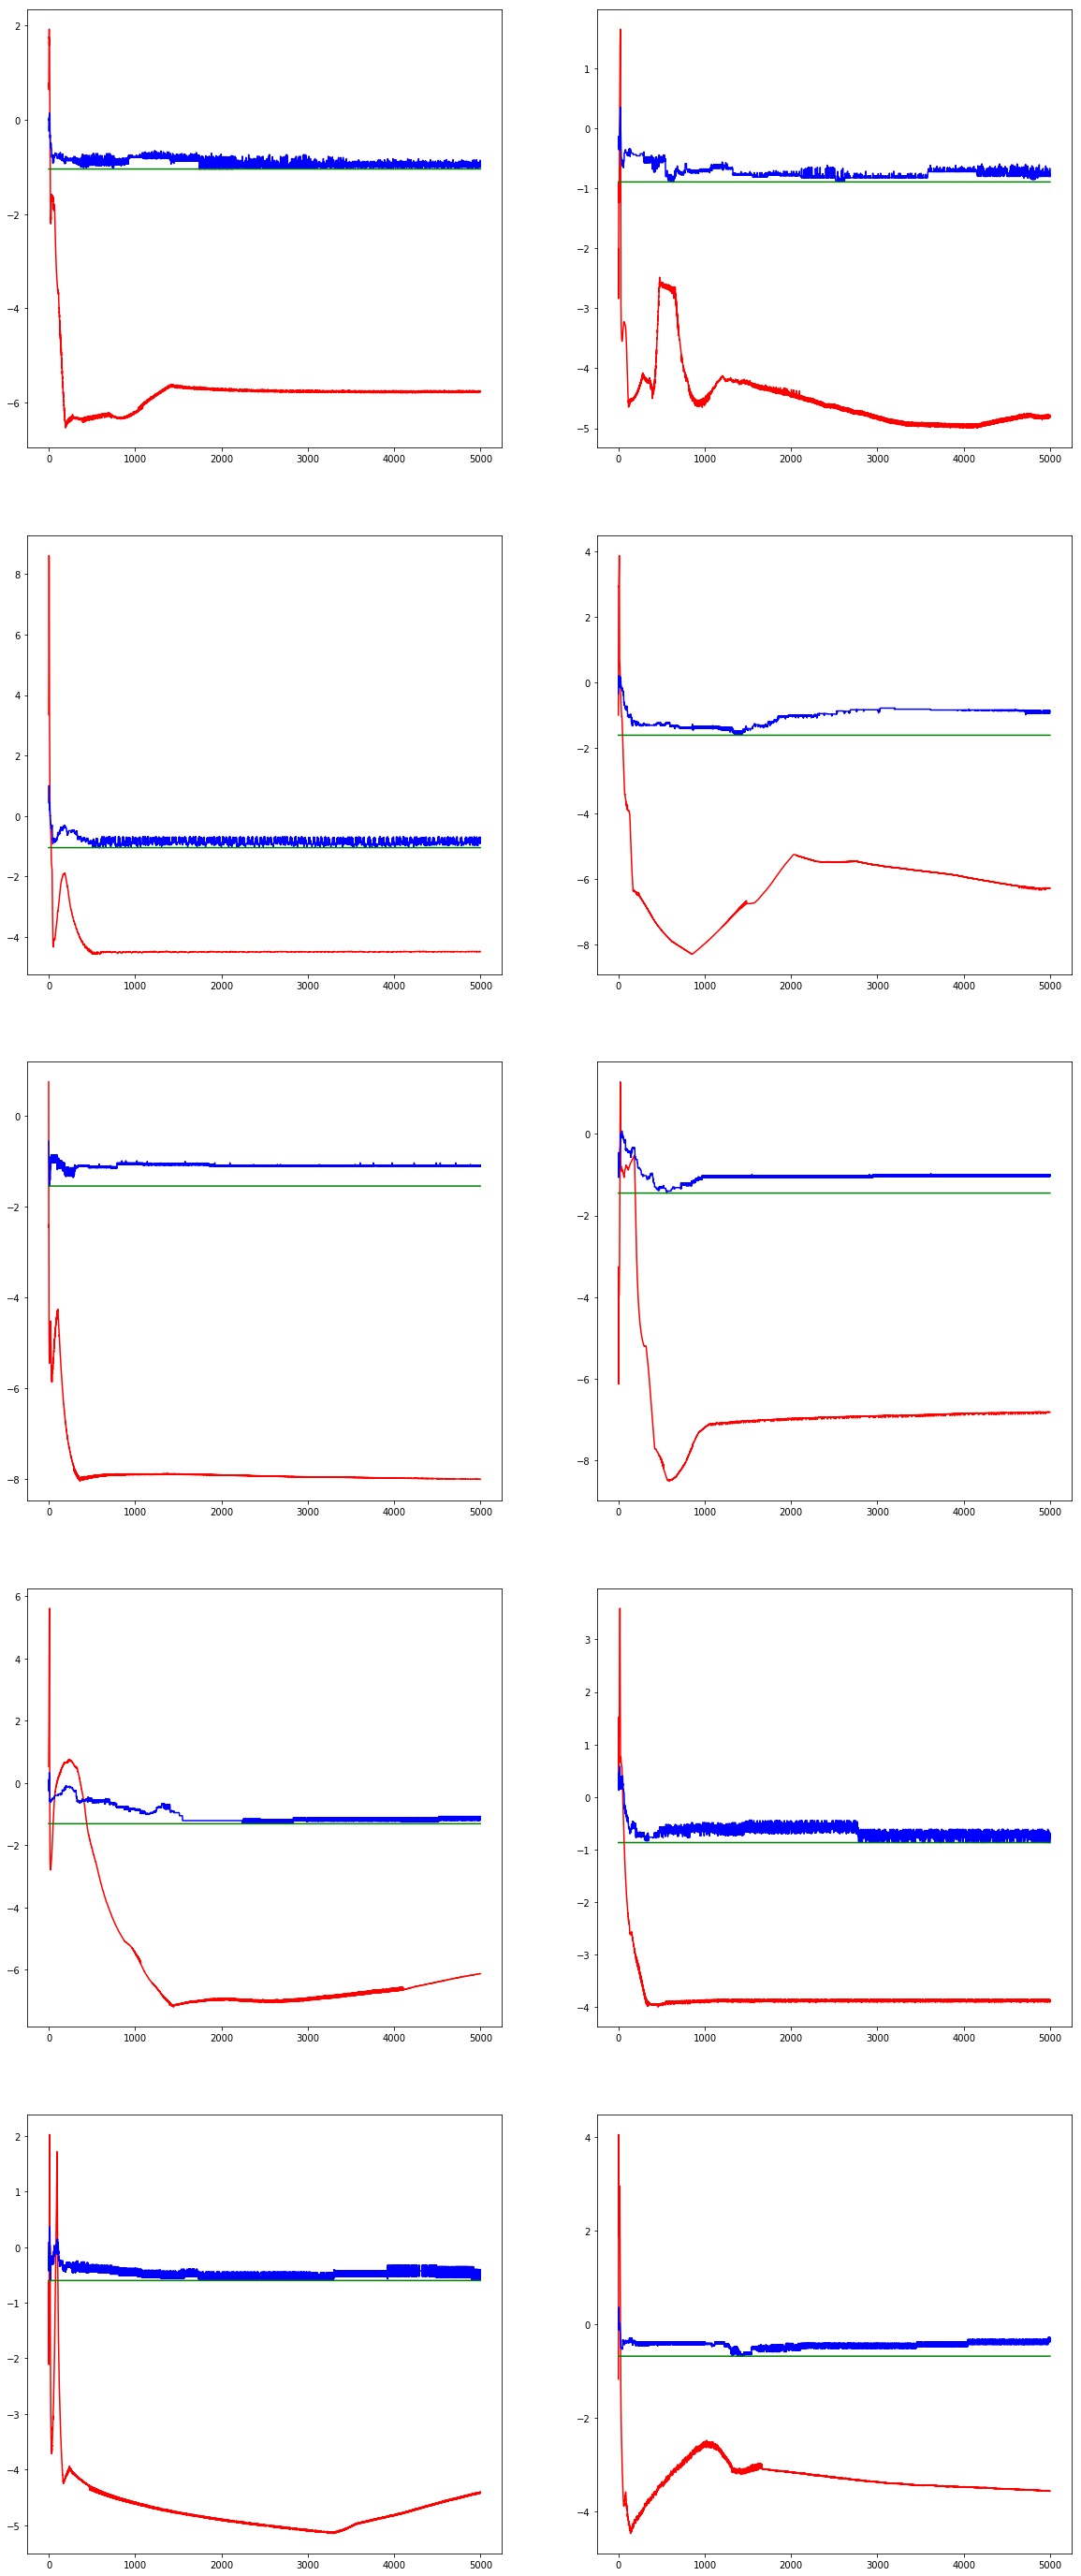

In [292]:
fig, axs = plt.subplots(5, 2, figsize=(20,50))
a = np.arange(iterations)
save_U = np.zeros([N, 10])

for i in range(10):
    
    np.random.seed(i)
    U = np.random.uniform(-1,1, N)[:,np.newaxis]
    temp_U = np.zeros(U.shape)
    temp_U = temp_U + U
    
    Ib_plot = np.zeros([iterations, 1])
    
    iterations = 5000

    art_loss, IB_loss, best_U, IB_min, count = gradient_descent(X_samples, Y_samples, temp_U, iterations, 1)
    print(best_U.shape)
    save_U[:,i] = save_U[:,i] + np.squeeze(best_U)
    
    axs[int(i%5), int(i/5)].plot(a,art_loss, c='r')
    axs[int(i%5), int(i/5)].plot(a,IB_loss, c='b')
    axs[int(i%5), int(i/5)].plot(a,Ib_plot + IB_min, c='g')
    
plt.show()

-1.0131746031746034 1.7416666666666663
-0.7895634920634922 1.7416666666666663
-1.0867857142857145 1.7416666666666663
-1.1762301587301587 1.7416666666666663
-0.5012301587301589 1.7416666666666663
-0.8012301587301589 1.7416666666666663
-0.8567857142857139 1.7416666666666663
-0.9978968253968254 1.7416666666666663
-0.7862301587301588 1.7416666666666663
-0.3250000000000002 1.7416666666666663


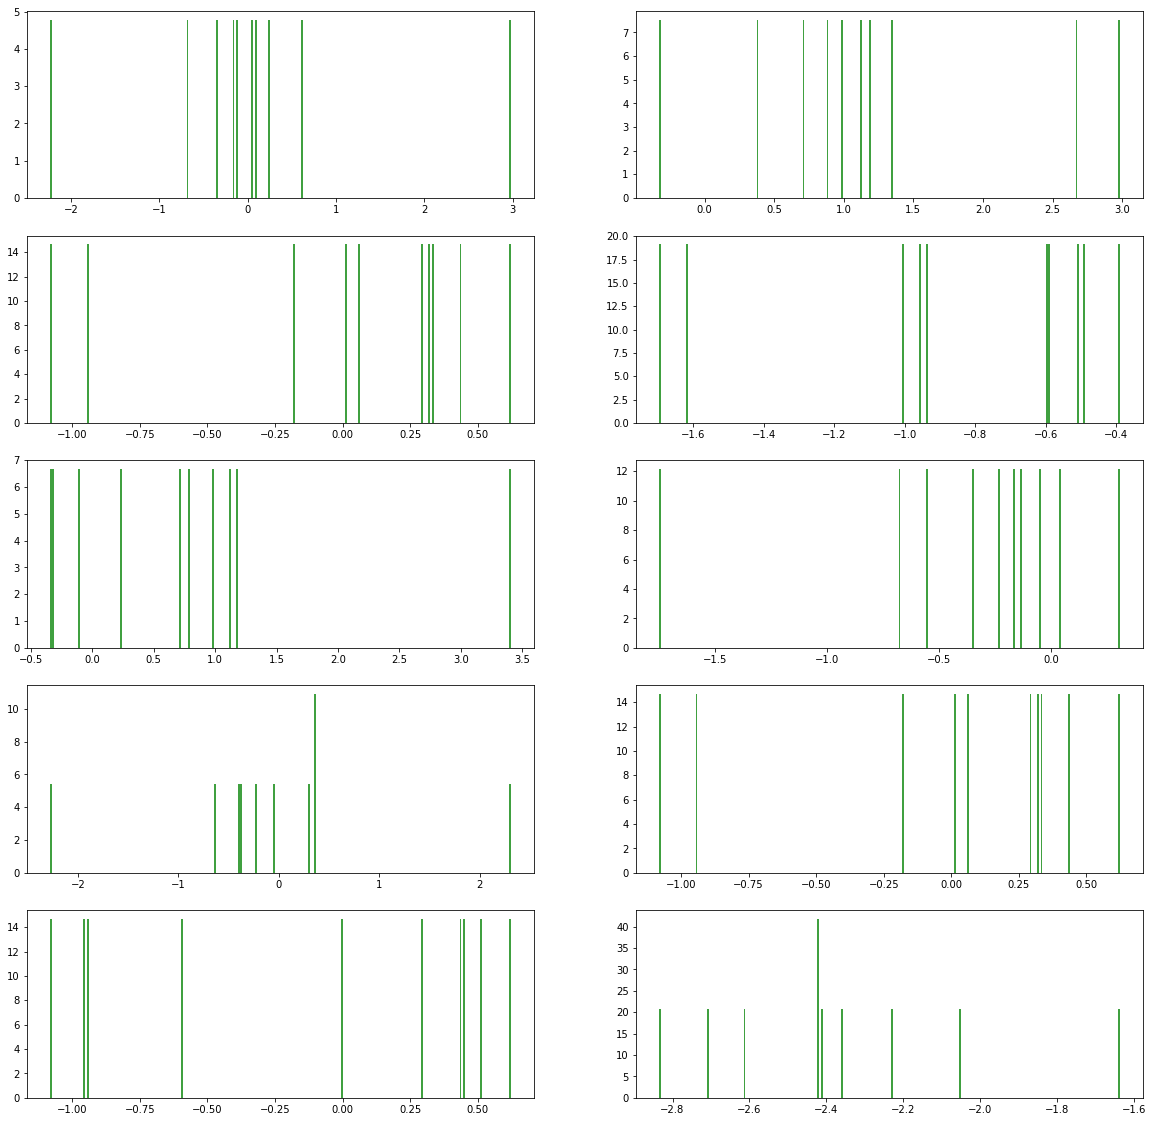

In [301]:
fig, axs = plt.subplots(5, 2, figsize=(20,20))

for i in range(10):
    print(IB(X_samples,Y_samples,save_U[:,i][:,np.newaxis],1,-1),IB(X_samples,Y_samples,rep[0],1,-1))
    n, bins, patches = axs[int(i%5), int(i/5)].hist(save_U[i,:], 250, density=True, facecolor='g', alpha=0.75)
    
plt.show()

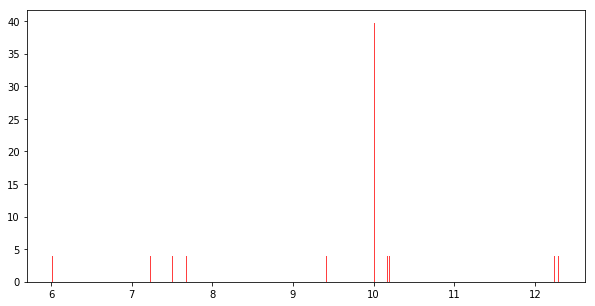

In [304]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

n, bins, patches = axs.hist(rep, 250, density=True, facecolor='r', alpha=0.75)
    
plt.show()



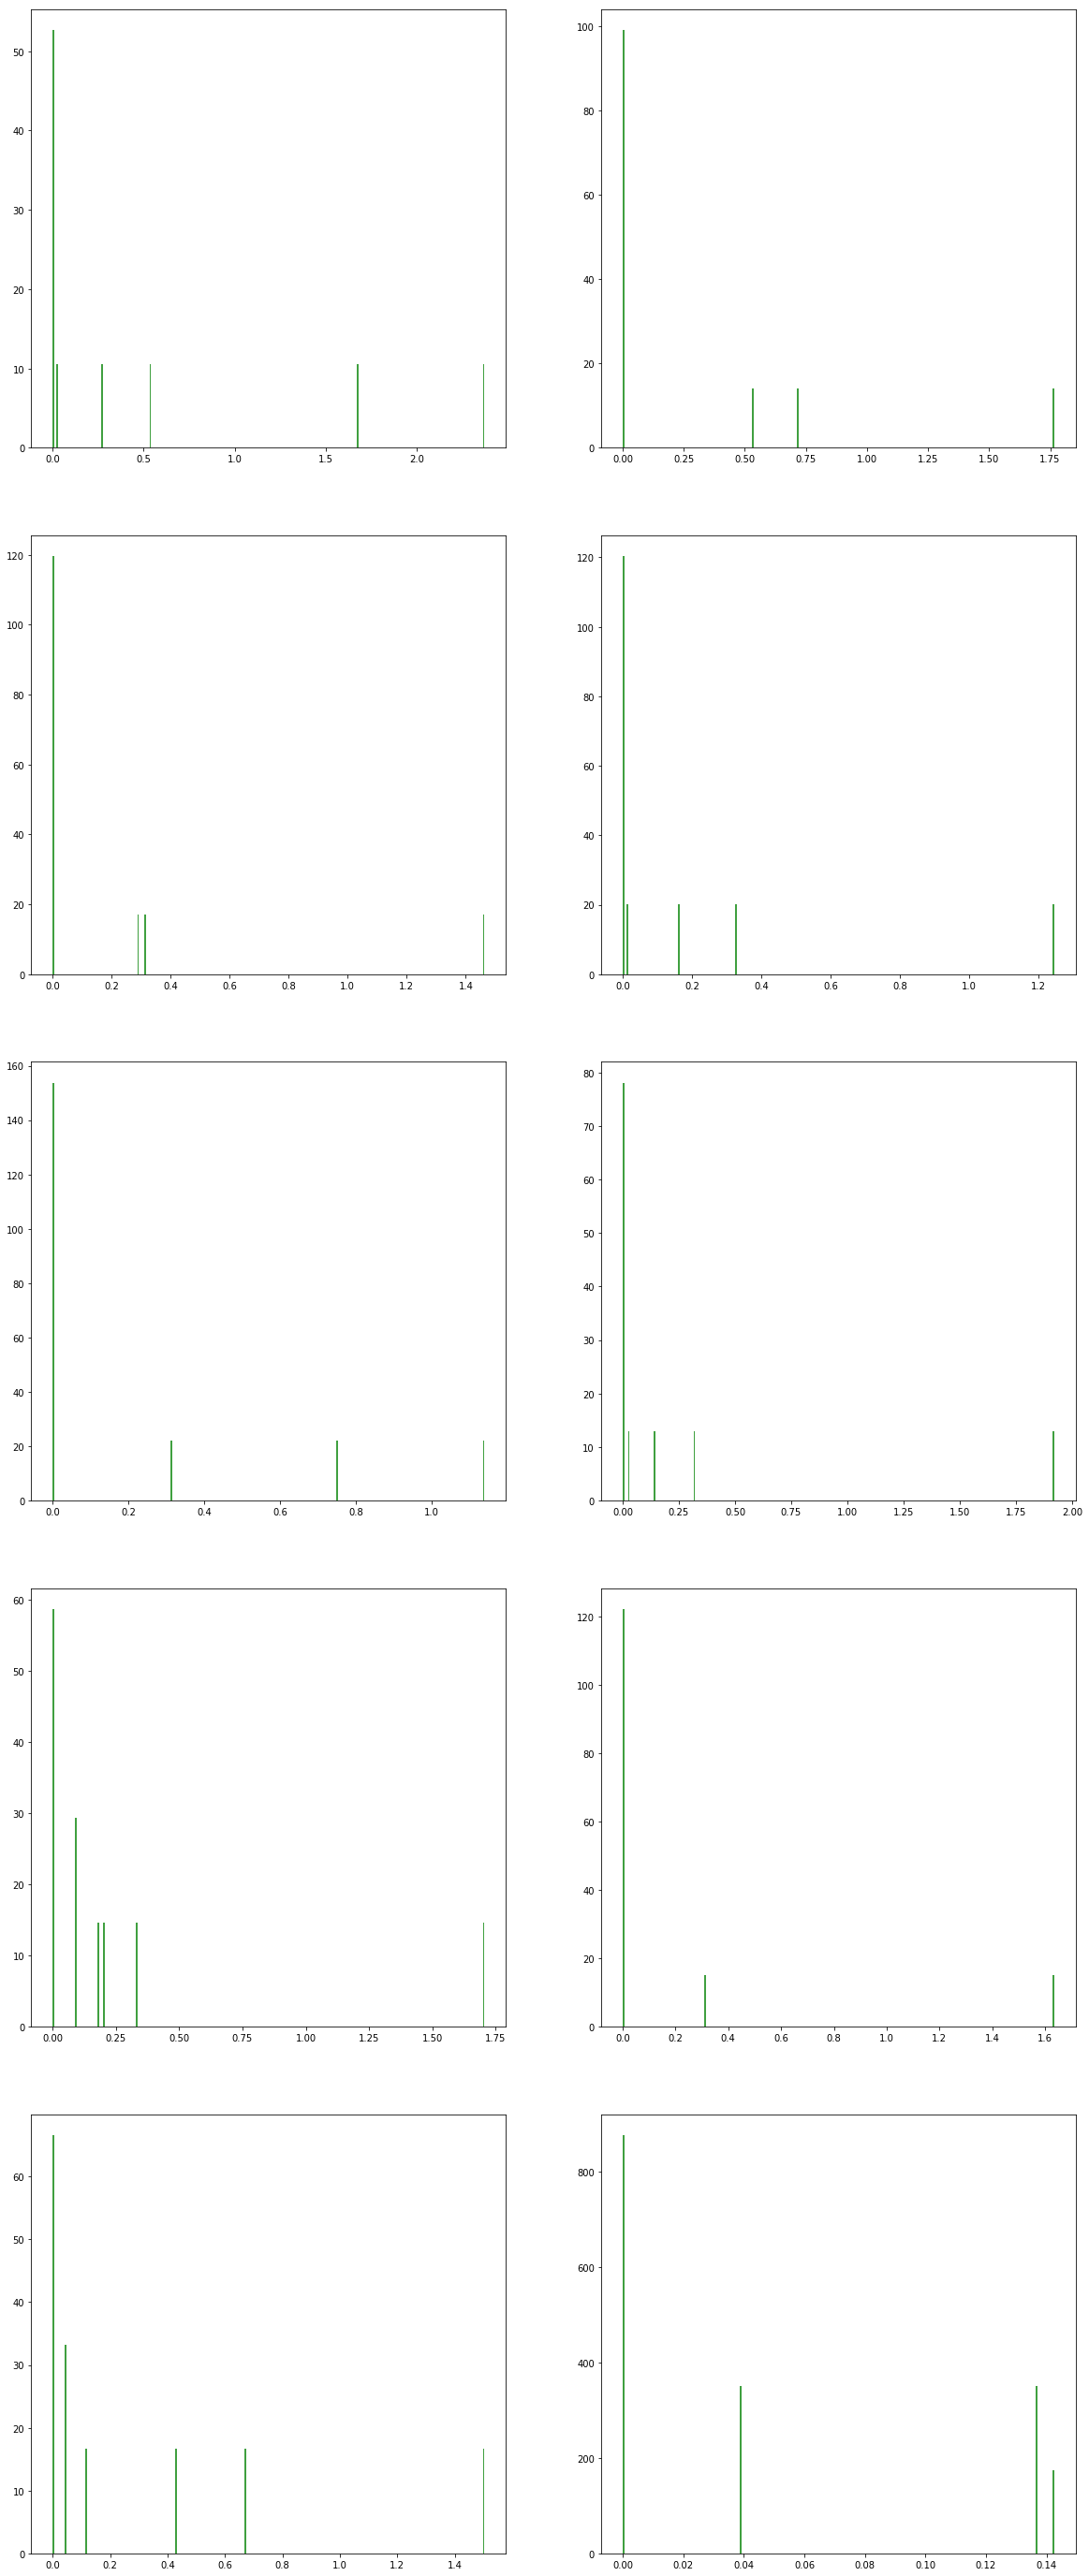

In [305]:
fig, axs = plt.subplots(5, 2, figsize=(20,50))

for i in range(10):
    dist_z, index_z = kNN(save_U[:,i][:,np.newaxis], save_U[:,i][:,np.newaxis], 1)
    #print(IB(X_samples,Y_samples,save_U[:,i][:,np.newaxis],1,-1),IB(X_samples,Y_samples,rep[0],1,-1))
    n, bins, patches = axs[int(i%5), int(i/5)].hist(dist_z[:,1], 250, density=True, facecolor='g', alpha=0.75)


In [ ]:
de ib_value(rho, rho_u):
    return 0.5 * np.log((1-rho*sigma*sigma)/(1-sigma*sigma))

x = np.linspace(0,1,100)
for i in x:
    

plt.plot(x, )